# Sequence Analysis with Neural Networks

This lecture is based on a Nature Genetics tutorial:

- **A Primer on Deep Learning in Genomics**, Zou et al. Nature Genetics 2018 [link](https://www.nature.com/articles/s41588-018-0295-5).
- notebook: https://colab.research.google.com/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb

# Background: Models for Transcription Factor Binding


<div>
   <img src="https://github.com/thomasmanke/ABS/raw/main/figures/ANN_TF_Bucher2020.png",  width="500">
</div>
(from Bucher 2020)


- short stretches (5-10 bp) of prefered DNA sequences
- binding energy models (physics)
- scoring models (statistics)
- **observations**
  - 1980 - 2000: small number (10-20) of known binding sites (heavily studied, databases)
  - since 2008: large scale experiments (ChIP-seq): thousands of binding sites

Below we will address this problem from a neural network perspective.
The main goal will be to derive a classifier to discriminate
*bound* sequences from *non-bound* sequences.

**Notice:** binding $\ne$ funcional binding

**Discussion:**
How should we define the input data (x) and output data (y)?

# Load Libraries

In [1]:
#!pip install Bio

     |████████████████████████████████| 270 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 9.6 MB/s eta 0:00:01
  Attempting uninstall: biopython
    Found existing installation: biopython 1.78
    Uninstalling biopython-1.78:
      Successfully uninstalled biopython-1.78


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix


import requests
import random
from Bio import SeqIO
from io import StringIO

# my plot function for confusion matrix
def plot_cm(mat):
  classes = np.arange(cm.shape[0])
  plt.imshow(mat, cmap=plt.cm.Blues)
  for (j,i),label in np.ndenumerate(mat):
    plt.text(i,j,np.round(label,2),ha='center',va='center')

  plt.colorbar()
  plt.title('Confusion Matrix')
  plt.xlabel('True label')
  plt.ylabel('Pred label')
  plt.xticks(classes)
  plt.yticks(classes)
  plt.show()

print('tensorflow: ', tf.__version__)

tensorflow:  2.4.1


# Read Data (sequences)

Here we read a fasta file with **positive** sequences = target sequences of the transcription factor of interest.

In [3]:
#url='https://jaspar.genereg.net/download/data/2022/sites/MA0036.2.sites' # the original
url='https://github.com/thomasmanke/ABS/raw/main/data/MA0036.2.sites'     # a copy
data = requests.get(url).text

seq_pos = []
for s in SeqIO.parse(StringIO(data), "fasta"):
  seq_pos.append(str(s.seq))

print('Read {} target sequences'.format(len(seq_pos)))

Read 4380 target sequences


# Clean Data

There is always some cleaning to be done (could have been done above)

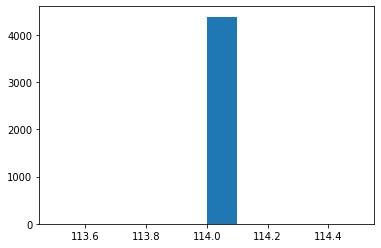

In [4]:
# capitalize all letters
seq_pos = [ s.upper() for s in seq_pos ]  

# in this example all sequences have the same length
# in general we would probably have to trim and or pad the sequences here
L = [len(item) for item in seq_pos]
plt.hist(L)
plt.show()

## Negative Dataset

Ideally we would like to have a set of non-target sequences.
In the absence of such a set, we define our own negative dataset by shuffeling. 

In [8]:
# define negative sequences (non targets)
seq_neg = [ ''.join(random.sample(s, len(s)) ) for s in seq_pos ]

# merge positive and negative sequences
seq = seq_pos + seq_neg

# define the corresponding labels (1=target, 0=non-target)
lab = [1]*len(seq_pos) + [0]*len(seq_neg)

## Encoding

In [9]:
nuc2int = {
    "A": 0,
    "C": 1,
    "T": 2,
    "G": 3,
    "N": 4,
}

int2nuc = dict((v, k) for k, v in nuc2int.items())

# integer encoding: A->0, C->1, ...
seq_i = [[nuc2int[letter] for letter in s] for s in seq]

# one-hot encoding: 0 -> [ 1 0 0 0 0], 1-> [0 1 0 0 0], ... 
seq_h = tf.one_hot(seq_i,depth=5, dtype=tf.float32)

lab_i = np.array(lab).reshape(-1,1)                 # integer encoding: list --> numpy
lab_h = tf.one_hot(lab,depth=2, dtype=tf.float32)   # one-hot encoded: list -> tf.EagerTensor 
print(lab_i.shape, lab_h.shape)
print(type(lab_i), type(lab_h))

2022-06-20 13:54:58.805457: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 13:54:58.806115: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 13:54:58.806647: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(8760, 1) (8760, 2)
<class 'numpy.ndarray'> <class 'tensorflow.python.framework.ops.EagerTensor'>


## Split Data: Train & Test

In [10]:
from sklearn.model_selection import train_test_split

seq_h=np.array(seq_h)  # tf --> numpy
lab_h=np.array(lab_h)  # tf  --> numpy

X_train, X_test, y_train, y_test = train_test_split(
  seq_h, lab_h, test_size=0.20, random_state=42)

print('X_train:    ', X_train.shape)
print('y_train:    ', y_train.shape)
print('train-test: ', len(y_train), len(y_test))

X_train:     (7008, 114, 5)
y_train:     (7008, 2)
train-test:  7008 1752


## Define Model

In [11]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

# Define input shape and output dimensions - for each sample
x_s = X_train.shape[1:] # feature (x) shape (skip first sample axis [0])
nc = y_train.shape[1]   # number of classes (=1 without one-hot encoding)

l_name='binary_crossentropy' 
a_name='binary_accuracy'

model = Sequential(name='Nanog_CNN_1')
model.add(Conv1D(filters=32, kernel_size=12, input_shape=x_s))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(nc, activation='softmax')) 

model.compile(optimizer='adam', loss=l_name, metrics=a_name)

model.summary()

Model: "Nanog_CNN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 103, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12816     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 14,802
Trainable params: 14,802
Non-trainable params: 0
_________________________________________________________________


## Fit Model

In [12]:
fh = model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
model_fn   = model.name + '.h5'
history_fn = model.name + '_history.npy'



2022-06-20 14:13:41.565969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-20 14:13:41.567693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2711995000 Hz


Epoch 1/20
198/198 [==============================] - 14s 52ms/step - loss: 0.5625 - binary_accuracy: 0.7044 - val_loss: 0.0526 - val_binary_accuracy: 0.9957
Epoch 2/20
198/198 [==============================] - 9s 46ms/step - loss: 0.0297 - binary_accuracy: 0.9980 - val_loss: 0.0133 - val_binary_accuracy: 0.9971
Epoch 3/20
198/198 [==============================] - 10s 52ms/step - loss: 0.0085 - binary_accuracy: 0.9993 - val_loss: 0.0074 - val_binary_accuracy: 0.9971
Epoch 4/20
198/198 [==============================] - 9s 47ms/step - loss: 0.0046 - binary_accuracy: 0.9996 - val_loss: 0.0055 - val_binary_accuracy: 0.9971
Epoch 5/20
198/198 [==============================] - 10s 49ms/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 0.0074 - val_binary_accuracy: 0.9971
Epoch 6/20
198/198 [==============================] - 11s 53ms/step - loss: 0.0020 - binary_accuracy: 0.9996 - val_loss: 0.0039 - val_binary_accuracy: 0.9971
Epoch 7/20
198/198 [==============================] - 

In [14]:
model.save(model_fn)      # save model
#np.save(history_fn, fh)   # save history
np.save(history_fn, fh.history)

## Load Model

In [ ]:
#%%script echo run if necessary
model_fn   = model.name + '.h5'
history_fn = model.name + '_history.npy'
model = tf.keras.models.load_model(model_fn)        # load model
fh = np.load(history_fn, allow_pickle=True).item()  # load history

run if necessary


# Evaluation

Evaluate Model: Nanog_CNN_1
55/55 [==============================] - 2s 28ms/step - loss: 0.0018 - binary_accuracy: 0.9994


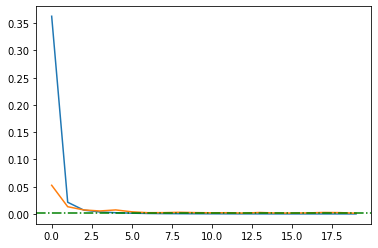

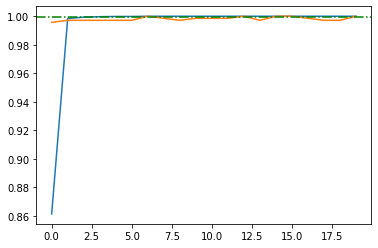

In [15]:
print('Evaluate Model:',model.name)
test_loss, test_acc = model.evaluate(X_test, y_test)

val_a_name = 'val_' + a_name
plt.plot(fh.history['loss'])    # When loading would need to be fh instead of fh.history since we can't save fh but only fh.history
plt.plot(fh.history['val_loss'])
plt.axhline(y=test_loss, color='green', linestyle='-.',label = 'test')
plt.show()

plt.plot(fh.history[a_name])
plt.plot(fh.history[val_a_name])
plt.axhline(y=test_acc, color='green', linestyle='-.',label = 'test')
plt.show()

# Predictions

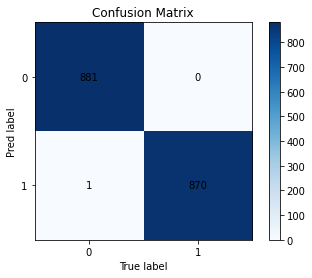

In [16]:
pred=model.predict(X_test)             # predicted class probabilities
pred_class = np.argmax(pred,axis=1)    # predicted classes
true_class = np.argmax(y_test,axis=1)  # true classes: one-hot encoded

cm=confusion_matrix(pred_class, true_class)
plot_cm(cm)

# Interpretations: Saliency Maps

So the classification accuracy appears very high. 

**Discussion:** Should we be concerned?

Now we want to understand which part of the sequence contributed most to the given classification (target/non-target)

Question: 
Which part of the input data contributes most strongly

In [17]:
! pip install tf-keras-vis

     |████████████████████████████████| 53 kB 772 kB/s eta 0:00:011
     |████████████████████████████████| 3.4 MB 5.0 MB/s eta 0:00:01


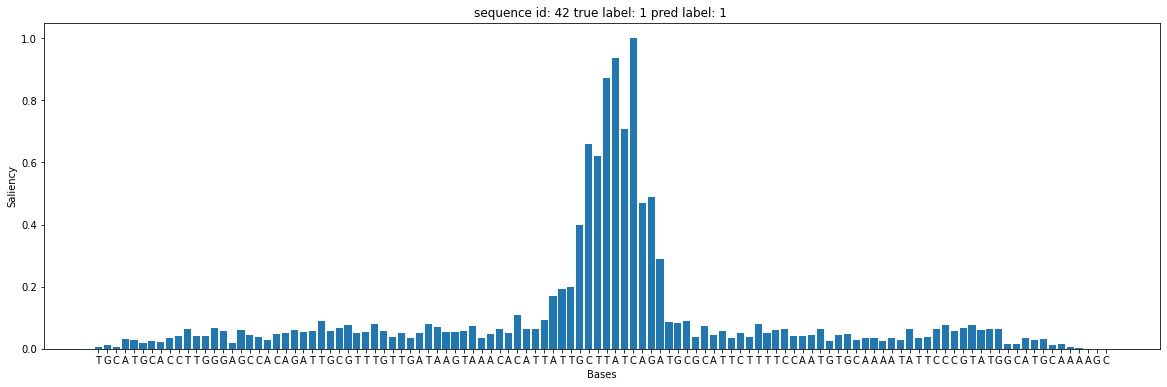

In [18]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

saliency = Saliency( model, model_modifier=ReplaceToLinear(), clone=True)

s_id = 42                                  # select sequence id
s_seq = X_test[s_id]                       # selected sequence (one hot encoded)
s_int = np.argmax(s_seq,axis=1)            # convert to integer
s_chr = list(map(int2nuc.get, s_int))      # map integer to DNA letters

s_class = pred_class[s_id]  # predicted class for s_id
t_class = true_class[s_id]  # true class for s_id

score = CategoricalScore(s_class)
sm    = saliency(score, s_seq)      # saliency map for one sequence
L     = sm.shape[1]                 # length of sequence

### plot  salience
plt.figure(figsize=[20,6])
barlist = plt.bar(np.arange(L), sm[0])
plt.xlabel('Bases')
plt.ylabel('Saliency')
plt.title('sequence id: {} true label: {} pred label: {} '.format(s_id, t_class, s_class))
plt.xticks(np.arange(L), list(s_chr))
plt.show()

Compare the Saliency Map with the known logo here: https://jaspar.genereg.net/matrix/MA0036.2/